# 都道府県ごとの集計データの扱い

都道府県ごとの合計データを処置変数と結果変数に使う場合

- 人口が交絡している
- 係数の解釈のため、１人あたりの値にして標準化したい

とい理由から、人口で割ったほうがいい


## 割ることが交絡のコントロールになる理由

#### 欠落変数バイアス

- long model: $y = \alpha p + \beta x + \varepsilon$
- short model: $y = \beta x + \varepsilon$

$p$は$x$にも影響を与えているとする

$p = \gamma_0 + \gamma_1 x + \epsilon$とおいてlong modelに代入すると

$$
y = \alpha (\gamma_0 + \gamma_1 x + \epsilon) + \beta x\\
= \alpha (\gamma_0 + \epsilon) + (\alpha \gamma_1 + \beta) x\\
$$

#### 割ることがコントロールになるのはなぜか

$$
y = \alpha p + \beta x + \varepsilon
$$

が

$$
\frac{y}{p} = \frac{\alpha p + \beta x + \varepsilon}{p}\\
= \alpha + \beta \frac{x}{p} + \frac{\varepsilon}{p}
$$






DGPを次のように仮定（$p$は人口）


$$
\begin{align}
x &= \alpha_x p + x^*\\
y &= \alpha_y p + \beta x
\end{align}
$$

$$
y = \alpha_y p + \beta (\alpha_x p + x^*)\\
= \alpha_y p + \beta \alpha_x p + \beta x^*
$$


## 想定するデータ生成過程に依存する？

### データ生成過程１

$y$のデータ生成過程を次のように想定する。$y$は$x$だけでなく人口$p$からの影響も受けており、$x$の項には$\beta x$だけだとする。
$x\to y$の効果$\beta$を推定したいとする。

$$
y = \alpha p + \beta x
$$

$y$を$p$で割った変換後の変数は、データ生成過程から次のようになると考えられる

$$
\frac{y}{p}= \frac{ \alpha p + \beta x }{p} = \alpha + \beta \frac{x}{p}
$$

この生成過程の下では、$\beta$を推定するためには$\dfrac{y}{p}$を$\dfrac{x}{p}$に回帰させる必要がある

### データ生成過程２

$y$のデータ生成過程を次のように想定する。$x$の項には$\beta x$だけでなく$p$も掛かっているとする。

$$
y = \alpha p + \beta x p 
$$

$y$を$p$で割った変換後の変数は、データ生成過程から次のようになると考えられる

$$
\frac{y}{p}= \frac{ \alpha p + \beta x p}{p} = \alpha + \beta x
$$

この生成過程の下では、$\beta$を推定するためには$\dfrac{y}{p}$を$x$に回帰させる必要がある


## データ１：人口と相関するx,y

データ生成過程を次のように、$x, y$ともに人口$p$からの影響を受けると想定する。

$$
\begin{align}
x &= \alpha_x p\\
y &= \alpha_y p + \beta x
\end{align}
$$

$x\to y$の効果である$\beta$を推定したい


yとxをpで割った変換後の変数は次のようになる

$$
\frac{y}{p}= \frac{\alpha_y p + \beta x}{p} = \alpha_y + \beta \frac{x}{p}
$$

なので、$\beta$を推定するためには$\dfrac{y}{p}$を$\dfrac{x}{p}$に回帰させる必要がある

もし$\dfrac{y}{p}$をそのままの$x$に回帰させると

$$
\begin{align}
\frac{y}{p} &= \alpha_y + \beta (\alpha_x p)\\
  &= (\alpha_y + \beta \alpha_x) p\\
\end{align}
$$

もし$x$を$p$で割らずにそのまま回帰させると

$$
\begin{align}
y &= \alpha_y p + \beta (\alpha_x p)\\
  &= (\alpha_y + \beta \alpha_x) p\\
\end{align}
$$

In [60]:
import numpy as np
import pandas as pd

np.random.seed(0)
n = 1000
populations = np.random.lognormal(mean=10, size=n).astype(int)
alpha_x = 0.1
alpha_y = 0.5
beta = 0.1
x = alpha_x * populations + np.random.normal(scale=1000, size=n)
y = alpha_y * populations + beta * x + np.random.normal(scale=1000, size=n)  # xとyは微弱な相関

In [61]:
df = pd.DataFrame(dict(y=y, x=x, population=populations)).sort_values("population").assign(
    # 人口あたりのy, xを計算する
    ypp = lambda self: self.y / self.population,
    xpp = lambda self: self.x / self.population,
)
df

,y,x,population,ypp,xpp
589,2549.340193,662.781881,1047,2.434900,0.633029
685,1382.162125,43.685046,1293,1.068958,0.033786
271,758.073247,1542.965439,1376,0.550925,1.121341
427,1615.118228,1120.767297,1422,1.135807,0.788163
334,970.870187,-458.525739,1541,0.630026,-0.297551
...,...,...,...,...,...
465,123228.375468,23928.854971,245844,0.501246,0.097333
734,136400.262268,26900.506639,267587,0.509742,0.100530
898,150004.237466,29789.613660,294909,0.508646,0.101013
494,166002.567127,30493.131436,326512,0.508412,0.093391


yppとxppの相関が弱いことから、
xとyの相関はpopulationによる交絡の影響を受けていることがわかる

<AxesSubplot:xlabel='xpp', ylabel='ypp'>

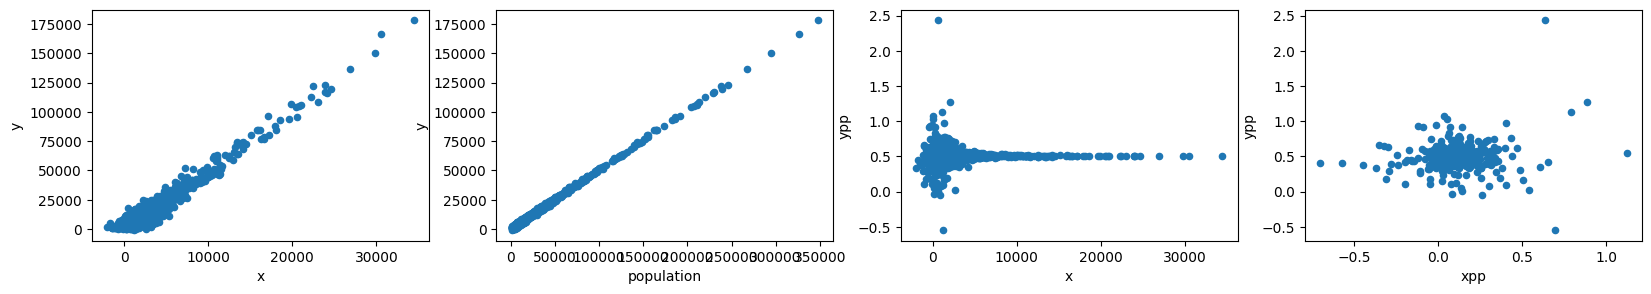

In [62]:
import matplotlib.pyplot as plt
fix, axes = plt.subplots(ncols=4, figsize=[20, 3])
df.plot.scatter(x="x", y="y", ax=axes[0])
df.plot.scatter(x="population", y="y", ax=axes[1])
df.plot.scatter(x="x", y="ypp", ax=axes[2])
df.plot.scatter(x="xpp", y="ypp", ax=axes[3])

しかし、可能なら`ypp ~ xpp`よりも`y ~ x + population`のほうが良い気がする

In [65]:
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

Stargazer([
    smf.ols("y ~ x", data=df).fit(),
    smf.ols("y ~ x + population", data=df).fit(),
    smf.ols("ypp ~ x", data=df).fit(),
    smf.ols("ypp ~ xpp", data=df).fit(),
])

## データ２：人口が部分的に影響する駅

データ生成過程を次のように想定する。$p$は人口、$s$は面積

$$
\begin{align}
x &= \alpha_x p + \gamma s \\
y &= \alpha_y p + \beta x
\end{align}
$$

$x\to y$の効果である$\beta$を推定したい

yをpで割った変換後の変数は

$$
\frac{y}{p} = \alpha_y + \beta \frac{x}{p}
$$

となるので、$\beta$を知りたいならやはり$\frac{x}{p}$を説明変数としたほうがいい


In [92]:
import numpy as np
import pandas as pd

np.random.seed(0)
n = 1000
populations = np.random.lognormal(mean=10, size=n).astype(int)
size = np.random.lognormal(mean=10, size=n).astype(int)
beta = -1
x = 0.5 * populations + 0.5 * size + np.random.normal(scale=1000, size=n)
y = 0.25 * populations + beta * x + np.random.normal(scale=1000, size=n)  # xとyは微弱な相関

In [93]:
df = pd.DataFrame(dict(y=y, x=x, population=populations, size=size)).sort_values("population").assign(
    # 人口あたりのy, xを計算する
    ypp = lambda self: self.y / self.population,
    xpp = lambda self: self.x / self.population,
    # 面積あたりのy, xを計算する
    yps = lambda self: self.y / self.size,
    xps = lambda self: self.x / self.size,
)
df

,y,x,population,size,ypp,xpp,yps,xps
589,-22259.518123,21726.562005,1047,38487,-21.260285,20.751253,-3.709920,3.103795
685,-12338.863722,11487.293621,1293,20219,-9.542818,8.884218,-2.056477,1.641042
271,-43709.248686,45504.776703,1376,89802,-31.765442,33.070332,-7.284875,6.500682
427,-31217.924818,30805.041498,1422,58604,-21.953534,21.663180,-5.202987,4.400720
334,-4475.946338,6984.722761,1541,11936,-2.904573,4.532591,-0.745991,0.997818
...,...,...,...,...,...,...,...,...
465,-65085.128773,126552.989971,245844,11435,-0.264742,0.514769,-10.847521,18.078999
734,-80569.609709,146401.211604,267587,25382,-0.301097,0.547116,-13.428268,20.914459
898,-87462.856618,161872.276100,294909,29694,-0.296576,0.548889,-14.577143,23.124611
494,-82865.501781,164225.753983,326512,2545,-0.253790,0.502970,-13.810917,23.460822


<AxesSubplot:xlabel='xps', ylabel='yps'>

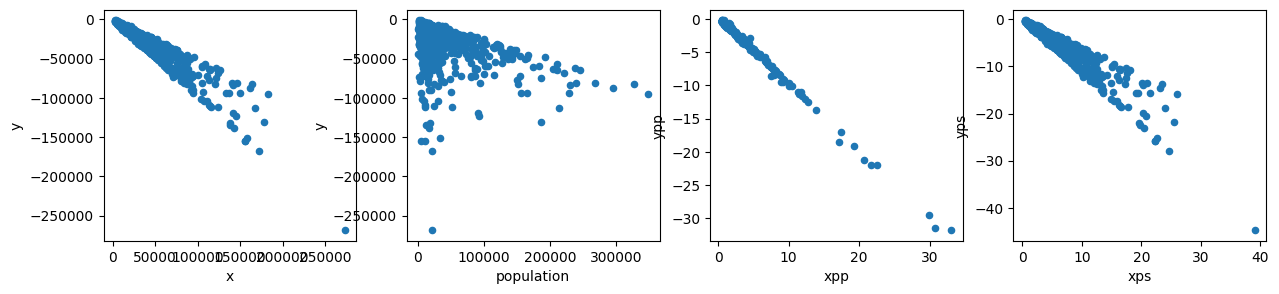

In [94]:
import matplotlib.pyplot as plt
fix, axes = plt.subplots(ncols=4, figsize=[15, 3])
df.plot.scatter(x="x", y="y", ax=axes[0])
df.plot.scatter(x="population", y="y", ax=axes[1])
df.plot.scatter(x="xpp", y="ypp", ax=axes[2])
df.plot.scatter(x="xps", y="yps", ax=axes[3])

In [95]:
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

Stargazer([
    smf.ols("y ~ x", data=df).fit(),
    smf.ols("y ~ x + population", data=df).fit(),
    smf.ols("ypp ~ xpp", data=df).fit(),
    smf.ols("ypp ~ xps", data=df).fit(),
    smf.ols("yps ~ xps", data=df).fit(),
])